In [22]:
import sys
import json
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))

from protocol.scoring.post_scorer import PostScorer

In [23]:
# Load query results from JSON file
data_path = Path('../data/posts.json')
with open(data_path, 'r') as f:
    query_results = json.load(f)

print(f"Loaded {len(query_results)} query results")

# Count unique UIDs and X user IDs
unique_uids = len(set(result['uid'] for result in query_results))
unique_x_user_ids = len(set(result['user_id'] for result in query_results))
print(f"Number of unique UIDs: {unique_uids}")
print(f"Number of unique X user ids: {unique_x_user_ids}")

# Count unique X posts
unique_tweet_ids = set()
for result in query_results:
    for tweet in result['tweets']:
        tweet_id = tweet['Tweet'].get('ID')
        if tweet_id:
            unique_tweet_ids.add(tweet_id)

print(f"Number of unique X posts: {len(unique_tweet_ids)}")

# Print detailed stats
total_queries = len(query_results)
total_tweets = sum(len(result['tweets']) for result in query_results)
unique_tweets = len(unique_tweet_ids)

print(f"\nDetailed Statistics:")
print(f"Total query results: {total_queries}")
print(f"Total X posts: {total_tweets}")
print(f"Unique X posts: {unique_tweets}")

# Check for queries with no tweets
empty_queries = sum(1 for result in query_results if len(result['tweets']) == 0)
print(f"Queries with no tweets: {empty_queries}")

Loaded 2865 query results
Number of unique UIDs: 220
Number of unique X user ids: 269
Number of unique X posts: 7803

Detailed Statistics:
Total query results: 2865
Total X posts: 7803
Unique X posts: 7803
Queries with no tweets: 0


In [24]:
# Create dictionaries to store tweets per user and user relationships
user_tweet_counts = {}
user_tweets = {}
uid_user_ids = {}  # Track multiple user_ids per uid

for result in query_results:
    user_id = result['user_id']
    uid = result['uid']
    subnet_id = result['subnet_id']
    
    # Track uid to user_id relationships
    if uid not in uid_user_ids:
        uid_user_ids[uid] = set()
    uid_user_ids[uid].add(user_id)
    
    if user_id not in user_tweets:
        user_tweets[user_id] = set()
    
    for tweet in result['tweets']:
        tweet_id = tweet['Tweet'].get('ID')
        if tweet_id:
            user_tweets[user_id].add(tweet_id)
            user_tweet_counts[user_id] = {
                'uid': uid,
                'subnet_id': subnet_id,
                'tweet_count': len(user_tweets[user_id])
            }

# Convert to DataFrame
df_users = pd.DataFrame([
    {'user_id': user_id, **stats}
    for user_id, stats in user_tweet_counts.items()
])
df_users = df_users.sort_values('tweet_count', ascending=False)

# Save to CSV
output_dir = '../data/csv'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'user_tweet_counts.csv')
df_users.to_csv(output_path, index=False)

# Print statistics about the uid to user_id relationships
print("\nUID to User ID relationships:")
for uid, user_ids in uid_user_ids.items():
    if len(user_ids) > 1:
        print(f"UID {uid} has {len(user_ids)} different user_ids: {user_ids}")
print(f"Total unique UIDs: {len(uid_user_ids)}")
print(f"Total unique X user ids: {len(user_tweet_counts)}")
print(f"Total unique tweets across all users: {sum(len(tweets) for tweets in user_tweets.values())}")
print(f"\nData saved to: {output_path}")
display(df_users)


UID to User ID relationships:
UID 27 has 2 different user_ids: {'2220312806', '1297280634'}
UID 100 has 2 different user_ids: {'1312967426259083265', '1794258621947412480'}
UID 98 has 2 different user_ids: {'1873777355703148548', '1312967426259083265'}
UID 28 has 2 different user_ids: {'1527734372966838273', '1872660653854674944'}
UID 47 has 2 different user_ids: {'213687954', '1873020879938195456'}
UID 114 has 2 different user_ids: {'1730677538', '1702157179'}
UID 105 has 2 different user_ids: {'1583121342571974656', '2759577472'}
UID 50 has 2 different user_ids: {'283331104', '1873135054378913792'}
UID 19 has 2 different user_ids: {'4477606516', '1871956303834185728'}
UID 109 has 2 different user_ids: {'1874651122608300032', '3955985836'}
UID 89 has 2 different user_ids: {'84118206', '384408291'}
UID 103 has 2 different user_ids: {'1868934473040990208', '456284582'}
UID 104 has 2 different user_ids: {'1362854823742308353', '1873518506928742400'}
UID 119 has 2 different user_ids: {'1

,user_id,uid,subnet_id,tweet_count
86,1770087158440976384,170,59,787
125,1859934851828195328,138,59,786
12,20510925,24,59,525
141,1775509072747560960,216,59,301
99,1870741658276376576,166,59,206
...,...,...,...,...
50,3313768127,25,59,1
94,1446355232439496714,176,59,1
60,628114213,34,59,1
239,1873122403569508352,68,59,1



Scoring Summary:
Total unique UIDs: 220
Total X posts scored: 7803
Date range: 2024-12-16 to 2025-01-02

UID Daily Average Scores:


timestamp,2024-12-16,2024-12-17,2024-12-18,2024-12-19,2024-12-20,2024-12-21,2024-12-22,2024-12-23,2024-12-24,2024-12-26,2024-12-27,2024-12-28,2024-12-29,2024-12-30,2024-12-31,2025-01-01,2025-01-02
uid,,,,,,,,,,,,,,,,,
148,NaN,NaN,NaN,NaN,NaN,0.271,NaN,0.230,0.261,0.275,NaN,0.261,0.268,0.270,0.264,0.338,0.447
132,NaN,NaN,NaN,0.180,0.164,NaN,0.162,0.301,NaN,0.347,NaN,0.272,0.297,NaN,0.230,0.445,0.447
227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.210,0.386,0.323,0.362,0.441,0.338,0.363,0.446,0.446
151,NaN,NaN,NaN,NaN,NaN,0.222,0.272,0.224,0.317,NaN,0.437,NaN,NaN,0.446,0.446,0.443,0.446
109,NaN,0.124,0.171,0.209,NaN,0.192,NaN,NaN,0.423,0.449,0.389,0.397,0.374,0.342,0.446,0.365,0.445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,NaN,NaN,NaN,NaN,NaN,0.161,NaN,NaN,0.445,0.447,0.444,0.442,NaN,0.350,NaN,0.341,NaN
94,NaN,NaN,0.232,0.223,NaN,0.192,NaN,0.428,0.451,0.446,0.372,0.442,0.443,0.292,0.249,0.276,NaN
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449,0.426,0.441,NaN,0.281,0.255,0.261,NaN


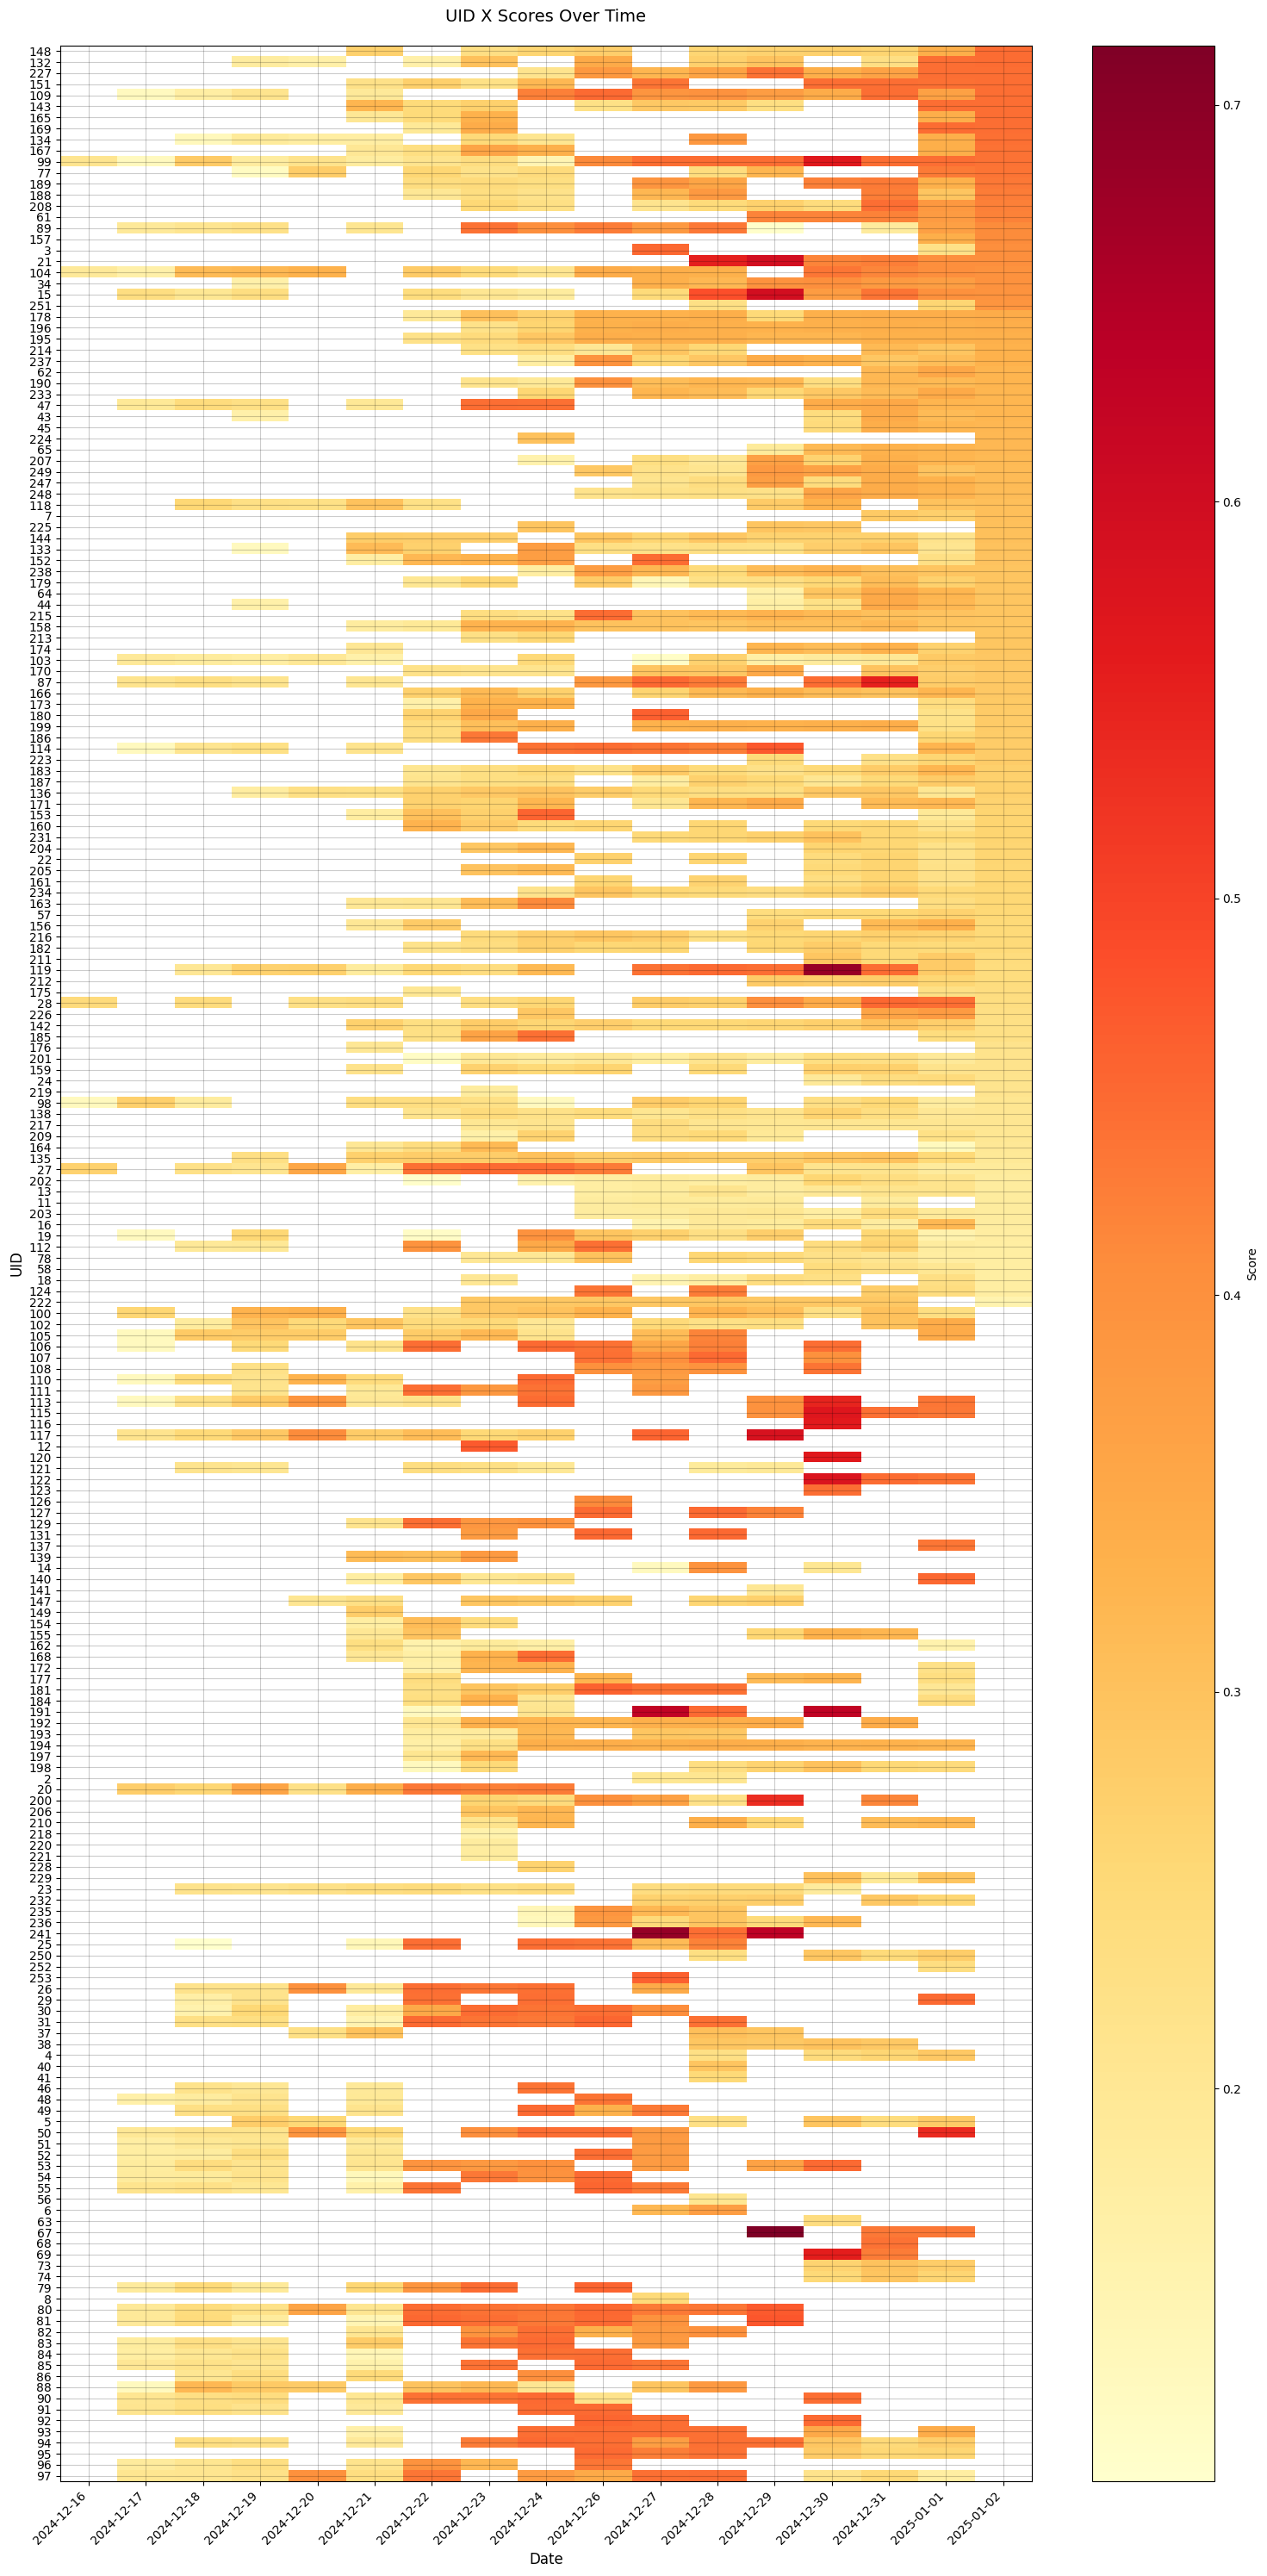

In [25]:
# Process and score tweets
uid_user_scores = defaultdict(lambda: defaultdict(list))
scorer = PostScorer()
scoring_records = []

# Score tweets and create records
for result in query_results:
    uid = result['uid']
    user_id = result['user_id']
    subnet_id = result['subnet_id']
    
    scored_posts = scorer.score_posts([{
        'uid': uid,
        'tweets': result['tweets']
    }])[0]
    
    for score_data in scored_posts['scores']:
        if not score_data['timestamp']:
            continue
            
        record = {
            'uid': uid,
            'user_id': user_id,
            'subnet_id': subnet_id,
            'tweet_id': score_data['tweet_id'],
            'score': score_data['score'],
            'timestamp': datetime.fromtimestamp(score_data['timestamp'])
        }
        scoring_records.append(record)
        uid_user_scores[uid][user_id].append(record)

# Create DataFrame and sort by timestamp
df_scores = pd.DataFrame(scoring_records)
df_scores = df_scores.sort_values(['uid', 'user_id', 'timestamp'])

# Create pivot table and sort by UID numerically
df_pivot = pd.pivot_table(
    df_scores,
    values='score',
    index='uid',
    columns=pd.Grouper(key='timestamp', freq='D'),
    aggfunc='mean'
).round(3)

# Convert index to numeric and sort by last column descending
df_pivot.index = pd.to_numeric(df_pivot.index)
df_pivot = df_pivot.sort_values(df_pivot.columns[-1], ascending=False)

# Print summary statistics
print("\nScoring Summary:")
print(f"Total unique UIDs: {len(uid_user_scores)}")
print(f"Total X posts scored: {len(scoring_records)}")
print(f"Date range: {df_scores['timestamp'].min().date()} to {df_scores['timestamp'].max().date()}")

# Display pivot table
print("\nUID Daily Average Scores:")
display(df_pivot)

# Create visualization
plt.figure(figsize=(15, 30))

# Create heatmap
plt.imshow(df_pivot, aspect='auto', cmap='YlOrRd')
plt.colorbar(label='Score')

plt.title('UID X Scores Over Time', pad=20, fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('UID', fontsize=12)

# Format x-axis (dates)
plt.xticks(range(len(df_pivot.columns)), 
           df_pivot.columns.date, 
           rotation=45, 
           ha='right',
           fontsize=10)

# Format y-axis (UIDs)
y_ticks = range(len(df_pivot.index))
plt.yticks(y_ticks, 
           df_pivot.index, 
           fontsize=10)

plt.grid(True, which='major', color='black', alpha=0.2)
plt.subplots_adjust(left=0.15)
plt.tight_layout()
plt.show()

# Save data
output_dir = '../data/csv'
os.makedirs(output_dir, exist_ok=True)
df_scores.to_csv(os.path.join(output_dir, 'tweet_scores_timeline.csv'), index=False)
df_pivot.to_csv(os.path.join(output_dir, 'uid_daily_scores.csv'))

Scoring Component Statistics:

Component Score Averages:
engagement_score     0.009819
content_score        0.405257
interaction_score    0.448183
final_score          0.259960
dtype: float64

Correlation Matrix:


,engagement_score,content_score,interaction_score,final_score
engagement_score,1.000000,0.097270,0.105866,0.343078
content_score,0.097270,1.000000,-0.112943,0.855898
interaction_score,0.105866,-0.112943,1.000000,0.374432
final_score,0.343078,0.855898,0.374432,1.000000


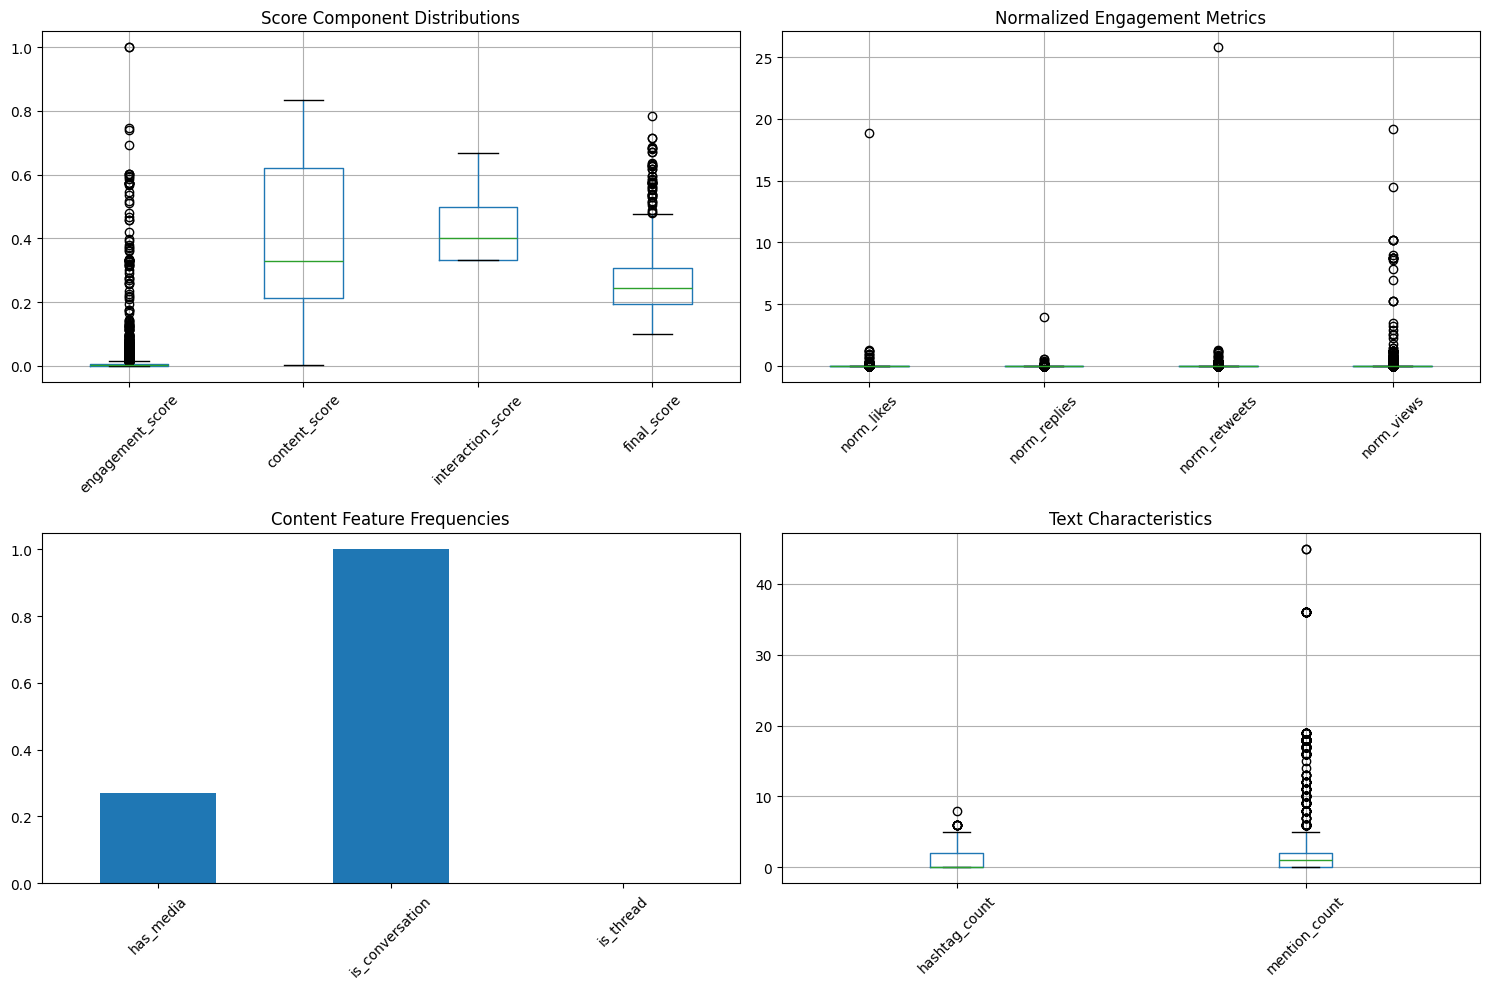

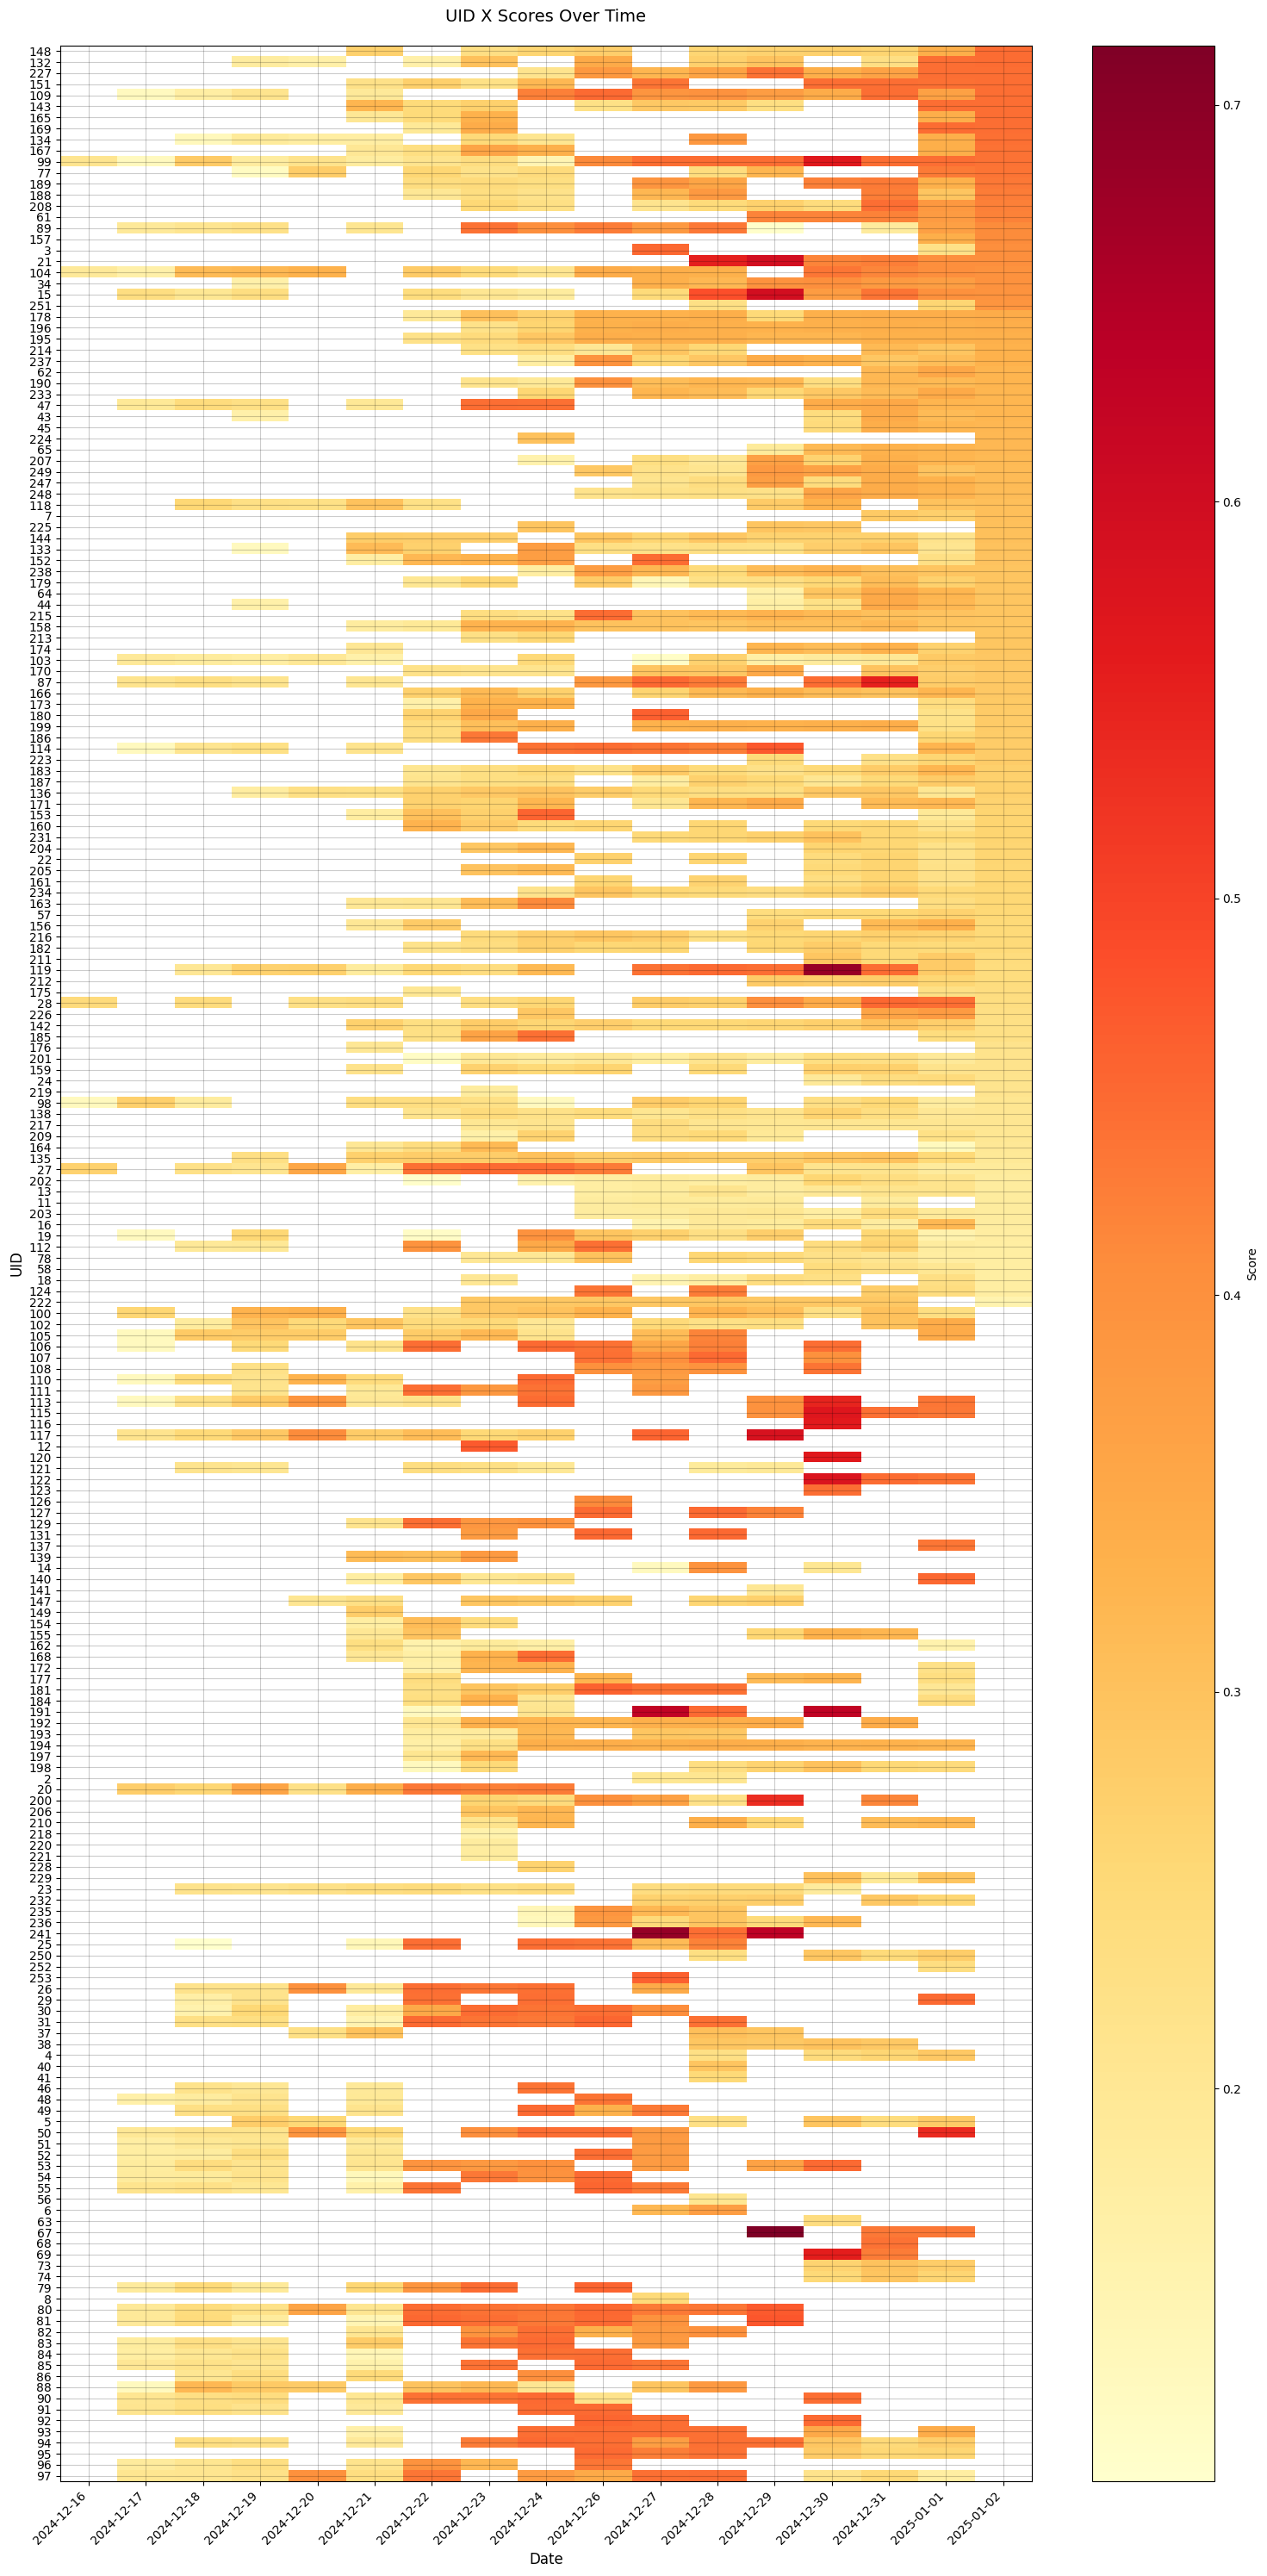


UID Daily Average Scores:


timestamp,2024-12-16,2024-12-17,2024-12-18,2024-12-19,2024-12-20,2024-12-21,2024-12-22,2024-12-23,2024-12-24,2024-12-26,2024-12-27,2024-12-28,2024-12-29,2024-12-30,2024-12-31,2025-01-01,2025-01-02
uid,,,,,,,,,,,,,,,,,
148,NaN,NaN,NaN,NaN,NaN,0.271,NaN,0.230,0.261,0.275,NaN,0.261,0.268,0.270,0.264,0.338,0.447
132,NaN,NaN,NaN,0.180,0.164,NaN,0.162,0.301,NaN,0.347,NaN,0.272,0.297,NaN,0.230,0.445,0.447
227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.210,0.386,0.323,0.362,0.441,0.338,0.363,0.446,0.446
151,NaN,NaN,NaN,NaN,NaN,0.222,0.272,0.224,0.317,NaN,0.437,NaN,NaN,0.446,0.446,0.443,0.446
109,NaN,0.124,0.171,0.209,NaN,0.192,NaN,NaN,0.423,0.449,0.389,0.397,0.374,0.342,0.446,0.365,0.445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,NaN,NaN,NaN,NaN,NaN,0.161,NaN,NaN,0.445,0.447,0.444,0.442,NaN,0.350,NaN,0.341,NaN
94,NaN,NaN,0.232,0.223,NaN,0.192,NaN,0.428,0.451,0.446,0.372,0.442,0.443,0.292,0.249,0.276,NaN
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449,0.426,0.441,NaN,0.281,0.255,0.261,NaN



For 2025-01-02:
UIDs with scores: 114
UIDs without scores: 106
Total UIDs: 220


In [28]:
# Analyze scoring components for each tweet
scorer = PostScorer()
component_scores = []

for result in query_results:
    uid = result['uid']
    user_id = result['user_id']
    
    for tweet in result['tweets']:
        tweet_data = tweet.get('Tweet', {})
        if not tweet_data.get('ID'):
            continue
            
        # Calculate individual component scores
        engagement_score = scorer.calculate_engagement_score(tweet_data)
        content_score = scorer.calculate_content_quality_score(tweet_data)
        interaction_score = scorer.calculate_interaction_score(tweet_data)
        final_score = scorer.calculate_tweet_score(tweet_data)
        
        # Get engagement metrics for analysis
        engagement_metrics = {
            'likes': tweet_data.get('Likes', 0) / scorer.engagement_norm['likes'],
            'replies': tweet_data.get('Replies', 0) / scorer.engagement_norm['replies'],
            'retweets': tweet_data.get('Retweets', 0) / scorer.engagement_norm['retweets'],
            'views': tweet_data.get('Views', 0) / scorer.engagement_norm['views']
        }
        
        # Check for media presence safely
        has_media = any([
            bool(tweet_data.get('Photos')),
            bool(tweet_data.get('Videos')),
            bool(tweet_data.get('GIFs')),
            bool(tweet_data.get('URLs'))
        ])
        
        # Safely get counts with None protection
        def safe_len(item):
            return len(item) if item is not None else 0
            
        component_scores.append({
            'uid': uid,
            'user_id': user_id,
            'tweet_id': tweet_data['ID'],
            'timestamp': datetime.fromtimestamp(tweet_data.get('Timestamp', 0)),
            'engagement_score': engagement_score,
            'content_score': content_score,
            'interaction_score': interaction_score,
            'final_score': final_score,
            'raw_likes': tweet_data.get('Likes', 0),
            'raw_replies': tweet_data.get('Replies', 0),
            'raw_retweets': tweet_data.get('Retweets', 0),
            'raw_views': tweet_data.get('Views', 0),
            'norm_likes': engagement_metrics['likes'],
            'norm_replies': engagement_metrics['replies'],
            'norm_retweets': engagement_metrics['retweets'],
            'norm_views': engagement_metrics['views'],
            'has_media': has_media,
            'hashtag_count': safe_len(tweet_data.get('Hashtags')),
            'text_length': safe_len(tweet_data.get('Text')),
            'is_conversation': bool(tweet_data.get('ConversationID')),
            'mention_count': safe_len(tweet_data.get('Mentions')),
            'is_thread': tweet_data.get('IsSelfThread', False)
        })

# Convert to DataFrame
df_components = pd.DataFrame(component_scores)

# Calculate correlations between components
correlation_matrix = df_components[[
    'engagement_score', 'content_score', 'interaction_score', 'final_score'
]].corr()

# Display summary statistics
print("Scoring Component Statistics:")
print("\nComponent Score Averages:")
print(df_components[[
    'engagement_score', 'content_score', 'interaction_score', 'final_score'
]].mean())

print("\nCorrelation Matrix:")
display(correlation_matrix)

# Create component analysis visualizations
plt.figure(figsize=(15, 10))

# Component score distributions
plt.subplot(2, 2, 1)
df_components.boxplot(column=[
    'engagement_score', 'content_score', 'interaction_score', 'final_score'
])
plt.title('Score Component Distributions')
plt.xticks(rotation=45)

# Engagement metrics
plt.subplot(2, 2, 2)
df_components.boxplot(column=['norm_likes', 'norm_replies', 'norm_retweets', 'norm_views'])
plt.title('Normalized Engagement Metrics')
plt.xticks(rotation=45)

# Content features
plt.subplot(2, 2, 3)
df_components[['has_media', 'is_conversation', 'is_thread']].mean().plot(kind='bar')
plt.title('Content Feature Frequencies')
plt.xticks(rotation=45)

# Text characteristics
plt.subplot(2, 2, 4)
df_components.boxplot(column=['hashtag_count', 'mention_count'])
plt.title('Text Characteristics')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Create pivot table for heatmap
df_pivot = pd.pivot_table(
    df_components,
    values='final_score',
    index='uid',
    columns=pd.Grouper(key='timestamp', freq='D'),
    aggfunc='mean'
).round(3)

# Convert index to numeric and sort by last column descending
df_pivot.index = pd.to_numeric(df_pivot.index)
df_pivot = df_pivot.sort_values(df_pivot.columns[-1], ascending=False)

# Create heatmap visualization
plt.figure(figsize=(15, 30))

# Create heatmap
plt.imshow(df_pivot, aspect='auto', cmap='YlOrRd')
plt.colorbar(label='Score')

plt.title('UID X Scores Over Time', pad=20, fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('UID', fontsize=12)

# Format x-axis (dates)
plt.xticks(range(len(df_pivot.columns)), 
           df_pivot.columns.date, 
           rotation=45, 
           ha='right',
           fontsize=10)

# Format y-axis (UIDs)
y_ticks = range(len(df_pivot.index))
plt.yticks(y_ticks, 
           df_pivot.index, 
           fontsize=10)

plt.grid(True, which='major', color='black', alpha=0.2)
plt.subplots_adjust(left=0.15)
plt.tight_layout()
plt.show()

# Display pivot table
print("\nUID Daily Average Scores:")
display(df_pivot)

# Save detailed analysis
output_dir = '../data/csv'
os.makedirs(output_dir, exist_ok=True)
df_components.to_csv(os.path.join(output_dir, 'tweet_scoring_components.csv'), index=False)
df_pivot.to_csv(os.path.join(output_dir, 'uid_daily_scores.csv'))

# Get the most recent date column
most_recent_date = df_pivot.columns[-1]

# Count UIDs with and without scores
uids_with_scores = df_pivot[most_recent_date].notna().sum()
uids_without_scores = df_pivot[most_recent_date].isna().sum()

print(f"\nFor {most_recent_date.date()}:")
print(f"UIDs with scores: {uids_with_scores}")
print(f"UIDs without scores: {uids_without_scores}")
print(f"Total UIDs: {len(df_pivot)}")